# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [4]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



## 是否支持GPU加速

In [5]:
USE_CUDA = torch.cuda.is_available()

# 读取MINST图形文件

In [6]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels.reshape(-1)

test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels.reshape(-1)#此处需要修改tensor
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [7]:
#提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 548),
#     torch.nn.BatchNorm1d(548),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(548, 10),
    torch.nn.Sigmoid()
#     torch.nn.BatchNorm1d(252),
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.2),
#     torch.nn.Linear(252, 10),
#     torch.nn.Sigmoid()
)
#检测是否需要gpu加速
if USE_CUDA:
    net.cuda()
#问题：如果要增加新的神经网络层怎么办？
#在Sequential里面增加新的隐含层，只要前后dimension一致

### 第二步：构造损失函数和优化器

In [8]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [9]:
#定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
#取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
   #计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案
    predictions = np.argmax(predictions, 1)
    return 100.0 - (
      100.0 *
      np.sum( predictions == labels) /
      predictions.shape[0])

In [10]:
#提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环


#神经网络训练循环
batch_size = 128
losses = []
errors = []
if USE_CUDA:
    for i in range(1500):
        #每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
        batch_loss = []
        batch_errors = []
        #start和end分别是提取一个batch数据的起始和终止下标
        for start in range(0, len(train_X), batch_size):
            end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
            xx = Variable(torch.FloatTensor(train_X[start:end])).cuda()#从训练数据train_X中提取数据
            yy = Variable(torch.LongTensor(train_Y[start:end])).cuda()  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
            predict = net(xx) #用神经网络进行预测
            loss = cost(predict, yy) #计算损失函数（交叉熵）
            err = error_rate(predict.data.cpu().numpy(), yy.data.cpu().numpy())
            optimizer.zero_grad() #清空梯度
            loss.backward() #开始反向传播
            optimizer.step() #开始更新梯度
            batch_loss.append(loss.data.cpu().numpy())
            batch_errors.append(err)

        #每隔100步输出一下损失值（loss）
        if i % 50==0:
            losses.append(np.mean(batch_loss))
            errors.append(np.mean(batch_errors))
            print(i, np.mean(batch_loss))
else:
    for i in range(1500):
        #每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
        batch_loss = []
        batch_errors = []
        #start和end分别是提取一个batch数据的起始和终止下标
        for start in range(0, len(train_X), batch_size):
            end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
            xx = Variable(torch.FloatTensor(train_X[start:end]))#从训练数据train_X中提取数据
            yy = Variable(torch.LongTensor(train_Y[start:end]))  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
            predict = net(xx) #用神经网络进行预测
            loss = cost(predict, yy) #计算损失函数（交叉熵）
            err = error_rate(predict.data.numpy(), yy.data.numpy())
            optimizer.zero_grad() #清空梯度
            loss.backward() #开始反向传播
            optimizer.step() #开始更新梯度
            batch_loss.append(loss.data.numpy())
            batch_errors.append(err)

        #每隔50步输出一下损失值（loss）
        if i % 50==0:
            losses.append(np.mean(batch_loss))
            errors.append(np.mean(batch_errors))
            print(i, np.mean(batch_loss))
    

0 1.89731
50 1.51193
100 1.49677
150 1.49018
200 1.48534
250 1.48237
300 1.48019
350 1.47888
400 1.47726
450 1.47609
500 1.47524
550 1.47442
600 1.47345
650 1.47286
700 1.47237
750 1.47188
800 1.47142
850 1.47125
900 1.47082
950 1.47041
1000 1.47008
1050 1.46989
1100 1.46946
1150 1.46908
1200 1.46881
1250 1.46871
1300 1.46834
1350 1.4684
1400 1.46804
1450 1.46785


### 请在这里写下你自己的回答

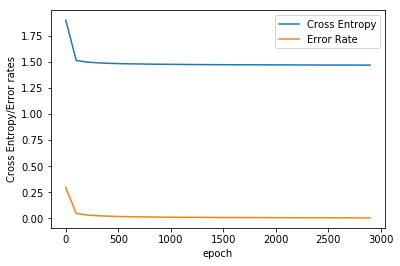

In [11]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
# 打印输出损失值
plt.plot(np.arange(len(losses))*100,losses, label = 'Cross Entropy')
plt.plot(np.arange(len(errors))*100, np.array(errors) / float(100), label = 'Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

### 第四步：在测试集上测试模型

In [12]:
#分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = start + batch_size if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    if USE_CUDA:
        net.cpu()
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions.data.numpy(), y.data.numpy())
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%'%np.mean(errors))

1 2.03
2 2.03606158833
3 2.08333333333
4 2.03826955075
5 2.11846543002
6 2.12606837607
7 2.01473136915
8 2.09797891037
9 2.15017825312
10 1.83092224231
11 1.99541284404
12 1.86219739292
13 1.81947069943
14 2.03934740883
15 2.08333333333
16 1.93069306931
17 1.86116700201
18 1.78936605317
19 1.80613305613
20 1.62526427061
21 1.68010752688
22 1.58643326039
23 1.5868596882
24 1.74319727891
25 1.63106235566
26 1.75
27 1.64868105516
28 1.69621026895
29 1.62094763092
30 1.74936386768
31 1.44480519481
32 1.52519893899
33 1.50745257453
34 1.43698060942
35 1.32790368272
36 1.41304347826
37 1.29821958457
38 1.13981762918
39 1.26557632399
40 1.25798722045
41 1.27049180328
42 1.30471380471
43 1.34083044983
44 1.15658362989
45 1.30494505495
46 1.10849056604
47 1.09435797665
48 0.978915662651
49 1.08921161826
50 1.01931330472
51 1.27777777778
52 1.26728110599
53 1.22607655502
54 0.901741293532
55 1.06865284974
56 1.0472972973
57 1.09463276836
58 1.33136094675
59 1.3198757764
60 1.26633986928
61 1.25


### 用单个图像进行测试

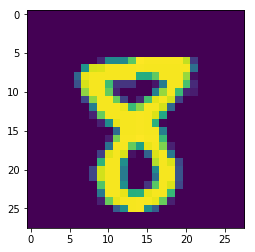

In [13]:
#随便从数据集中读入一张图片，并绘制出来
idx = 128
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [14]:
#计算识别结果
x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
predict = net(x)
np.argmax(predict.data.numpy())

8

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码